In [1]:
# import some libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd
df = pd.read_csv('../datasets/fer2013/fer2013/fer2013.csv')
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [2]:
# preprocessing of data by segregatting the training and test datas first

X_train = []
y_train = []
X_test = []
y_test = []
for index, row in df.iterrows():
    k = row['pixels'].split(" ")
    if row['Usage'] == 'Training':
        X_train.append(np.array(k))
        y_train.append(row['emotion'])
    elif row['Usage'] == 'PublicTest':
        X_test.append(np.array(k))
        y_test.append(row['emotion'])
print(X_train[0])

['70' '80' '82' ... '106' '109' '82']


In [3]:
#we convert the array elements from string to integer
X_train = np.array(X_train, dtype = 'uint8')
y_train = np.array(y_train, dtype = 'uint8')
X_test = np.array(X_test, dtype = 'uint8')
y_test = np.array(y_test, dtype = 'uint8')

In [4]:
# we oneHotencode it using the keras api to_categorical instead of oneHotencoding
#oneHotencoding and to_categorical are the same thing its just the matter of preference
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
y_train= to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)


(28709, 2304)


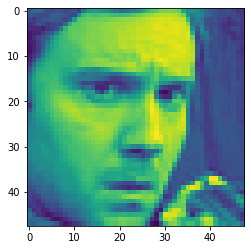

In [5]:
# we know that the X_train array contains 28709 rows with 2304 elements in each 
# so we also know this 2304 are pixels meaning the array should be converted to 48*48 which is 2304
print(np.shape(X_train))
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)
plt.imshow(X_train[0])
# basically we create a 4d tensor using reshape so X_train would be a 4d tensor with 28704 rows and 48 width and 48 height of each image and 1 is the grey rgb 
# here 1 is the grayscale form.. gray scale form means the colors are in the gray shades form

In [6]:
#some image augmentation to increase the number of images and make our model more robust
from keras.preprocessing.image import ImageDataGenerator 
datagen = ImageDataGenerator( 
    rescale=1./255,
    rotation_range = 10,
    horizontal_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode = 'nearest')
testgen = ImageDataGenerator(rescale=1./255)
datagen.fit(X_train)
batch_size = 64 
train_flow = datagen.flow(X_train, y_train, batch_size=batch_size) 
test_flow = testgen.flow(X_test, y_test, batch_size=batch_size)

In [7]:
# for the layers to be added to the model
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from tensorflow.keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

In [8]:
# lets create the model for our training:
def FER_Model(input_shape=(48,48,1)):
    # first input model
    visible = Input(shape=input_shape, name='input')
    num_classes = 7
    
    #the 1-st block 
    conv1_1 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_1')(visible)
    conv1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_2')(conv1_1)
    conv1_2 = BatchNormalization()(conv1_2)
    pool1_1 = MaxPooling2D(pool_size=(2,2), name = 'pool1_1')(conv1_2)
    drop1_1 = Dropout(0.3, name = 'drop1_1')(pool1_1)
    
    
    #the 2-nd block
    conv2_1 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_1')(drop1_1)
    conv2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_2')(conv2_1)
    conv2_2 = BatchNormalization()(conv2_2)
    conv2_3 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_3')(conv2_2)
    conv2_2 = BatchNormalization()(conv2_3)
    pool2_1 = MaxPooling2D(pool_size=(2,2), name = 'pool2_1')(conv2_3)
    drop2_1 = Dropout(0.3, name = 'drop2_1')(pool2_1)
    
    #the 3-rd block
    conv3_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_1')(drop2_1)
    conv3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_2')(conv3_1)
    conv3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_3')(conv3_2)
    conv3_3 = BatchNormalization()(conv3_3)
    conv3_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_4')(conv3_3)
    conv3_4 = BatchNormalization()(conv3_4)
    pool3_1 = MaxPooling2D(pool_size=(2,2), name = 'pool3_1')(conv3_4)
    drop3_1 = Dropout(0.3, name = 'drop3_1')(pool3_1)
    
    #the 4-th block
    conv4_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_1')(drop3_1)
    conv4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_2')(conv4_1)
    conv4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_3')(conv4_2)
    conv4_3 = BatchNormalization()(conv4_3)
    conv4_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_4')(conv4_3)
    conv4_4 = BatchNormalization()(conv4_4)
    pool4_1 = MaxPooling2D(pool_size=(2,2), name = 'pool4_1')(conv4_4)
    drop4_1 = Dropout(0.3, name = 'drop4_1')(pool4_1)
    
    #the 5-th block
    conv5_1 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_1')(drop4_1)
    conv5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_2')(conv5_1)
    conv5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_3')(conv5_2)
    conv5_3 = BatchNormalization()(conv5_3)
    conv5_4 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_4')(conv5_3)
    conv5_3 = BatchNormalization()(conv5_3)
    pool5_1 = MaxPooling2D(pool_size=(2,2), name = 'pool5_1')(conv5_4)
    drop5_1 = Dropout(0.3, name = 'drop5_1')(pool5_1)
    
    #Flatten and output
    flatten = Flatten(name = 'flatten')(drop5_1)
    ouput = Dense(num_classes, activation='softmax', name = 'output')(flatten)# create model 
    model = Model(inputs =visible, outputs = ouput)
    
    # summary layers
    print(model.summary())
    
    return model

In [9]:
model = FER_Model()
opt = Adam(lr=0.0001, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 48, 1)]       0         
                                                                 
 conv1_1 (Conv2D)            (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv1_2 (Conv2D)            (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 pool1_1 (MaxPooling2D)      (None, 24, 24, 64)        0     

C:\Users\Archit\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [10]:
num_epochs = 100  
history = model.fit(train_flow, 
                    steps_per_epoch=len(X_train) / batch_size, 
                    epochs=num_epochs,  
                    # verbose=1,  
                    validation_data=test_flow,
                    validation_steps=len(X_test) / batch_size)

Epoch 1/100
448/448 [==============================] - 73s 135ms/step - loss: 2.0137 - accuracy: 0.2146 - val_loss: 1.8430 - val_accuracy: 0.2466
Epoch 2/100
448/448 [==============================] - 57s 128ms/step - loss: 1.7883 - accuracy: 0.2520 - val_loss: 1.8039 - val_accuracy: 0.2552
Epoch 3/100
448/448 [==============================] - 57s 128ms/step - loss: 1.7591 - accuracy: 0.2718 - val_loss: 1.7423 - val_accuracy: 0.2934
Epoch 4/100
448/448 [==============================] - 58s 129ms/step - loss: 1.7059 - accuracy: 0.3113 - val_loss: 1.9012 - val_accuracy: 0.3006
Epoch 5/100
448/448 [==============================] - 58s 129ms/step - loss: 1.6334 - accuracy: 0.3541 - val_loss: 1.6497 - val_accuracy: 0.3856
Epoch 6/100
448/448 [==============================] - 58s 129ms/step - loss: 1.5664 - accuracy: 0.3864 - val_loss: 1.4933 - val_accuracy: 0.4333
Epoch 7/100
448/448 [==============================] - 58s 129ms/step - loss: 1.4930 - accuracy: 0.4235 - val_loss: 1.3671 -

In [11]:
# creating the weights and the json file
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [22]:
# reading the weights and the json file
from tensorflow.keras.models import model_from_json
model = model_from_json(open("model.json", "r").read())
model.load_weights('model.h5')

In [23]:
import cv2
face_haar_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [1]:
cap=cv2.VideoCapture(0)
while cap.isOpened():
    res,frame=cap.read()
    height, width , channel = frame.shape
    #---------------------------------------------------------------------------
    # Creating an Overlay window to write prediction and cofidencesub_img = frame[0:int(height/6),0:int(width)]black_rect = np.ones(sub_img.shape, dtype=np.uint8)*0
    res = cv2.addWeighted(sub_img, 0.77, black_rect,0.23, 0)
    FONT = cv2.FONT_HERSHEY_SIMPLEX
    FONT_SCALE = 0.8
    FONT_THICKNESS = 2
    lable_color = (10, 10, 255)
    lable = "Detector"
    lable_dimension = cv2.getTextSize(lable,FONT ,FONT_SCALE,FONT_THICKNESS)[0]
    textX = int((res.shape[1] - lable_dimension[0]) / 2)
    textY = int((res.shape[0] + lable_dimension[1]) / 2)
    cv2.putText(res, lable, (textX,textY), FONT, FONT_SCALE, (0,0,0), FONT_THICKNESS)
    # prediction part --------------------------------------------------------------------------gray_image= cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_haar_cascade.detectMultiScale(gray_image )
    try:
        for (x,y, w, h) in faces:
            cv2.rectangle(frame, pt1 = (x,y),pt2 = (x+w, y+h), color = (255,0,0),thickness =  2)
            roi_gray = gray_image[y-5:y+h+5,x-5:x+w+5]
            roi_gray=cv2.resize(roi_gray,(48,48))
            image_pixels = img_to_array(roi_gray)
            image_pixels = np.expand_dims(image_pixels, axis = 0)
            image_pixels /= 255
            predictions = model.predict(image_pixels)
            max_index = np.argmax(predictions[0])
            emotion_detection = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
            emotion_prediction = emotion_detection[max_index]
            cv2.putText(res, "Sentiment: {}".format(emotion_prediction), (0,textY+22+5), FONT,0.7, lable_color,2)
            lable_violation = 'Confidence: {}'.format(str(np.round(np.max(predictions[0])*100,1))+ "%")
            violation_text_dimension = cv2.getTextSize(lable_violation,FONT,FONT_SCALE,FONT_THICKNESS )[0]
            violation_x_axis = int(res.shape[1]- violation_text_dimension[0])
            cv2.putText(res, lable_violation, (violation_x_axis,textY+22+5), FONT,0.7, lable_color,2)
    except :
        pass
    frame[0:int(height/6),0:int(width)] = res
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        breakcap.release()
cv2.destroyAllWindows

NameError: name 'cv2' is not defined